<a href="https://colab.research.google.com/github/ben-fajack/Adult_Income_Preds/blob/main/Copy_of_Adult_Income_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Adult Income Predictions and Analysis**

**Author: Ben Fajack**

In [ ]:
# import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns',100)
# Import modeling tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# set the default output to pandas
from sklearn import set_config
set_config(transform_output='pandas')

In [ ]:
import warnings

# ignore warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## CLASSIFICATION METRICS AND FUNCTIONS
# Define Our Custom Functions
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [ ]:
fpath = "/content/drive/MyDrive/Advanced ML/Data/adult.csv"
df = pd.read_csv(fpath)
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [ ]:
df.tail(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
48841,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [ ]:
# dropping 'education' as it is redundant with the presence of 'educational-num'
df = df.drop('education', axis=1)

In [ ]:
df.shape

(48842, 14)

In [ ]:
df.dtypes

age                 int64
workclass          object
fnlwgt              int64
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   educational-num  48842 non-null  int64 
 4   marital-status   48842 non-null  object
 5   occupation       48842 non-null  object
 6   relationship     48842 non-null  object
 7   race             48842 non-null  object
 8   gender           48842 non-null  object
 9   capital-gain     48842 non-null  int64 
 10  capital-loss     48842 non-null  int64 
 11  hours-per-week   48842 non-null  int64 
 12  native-country   48842 non-null  object
 13  income           48842 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.2+ MB


In [ ]:
df.describe().round(2)

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.00,48842.00,48842.00,48842.00,48842.0,48842.00
mean,38.64,189664.13,10.08,1079.07,87.5,40.42
std,13.71,105604.03,2.57,7452.02,403.0,12.39
min,17.00,12285.00,1.00,0.00,0.0,1.00
25%,28.00,117550.50,9.00,0.00,0.0,40.00
50%,37.00,178144.50,10.00,0.00,0.0,40.00
75%,48.00,237642.00,12.00,0.00,0.0,45.00
max,90.00,1490400.00,16.00,99999.00,4356.0,99.00


In [ ]:
# duplicates
duplicated_rows = df.duplicated()
duplicated_rows

0        False
1        False
2        False
3        False
4        False
         ...  
48837    False
48838    False
48839    False
48840    False
48841    False
Length: 48842, dtype: bool

In [ ]:
# count the duplicates
df.duplicated().sum()

52

In [ ]:
# visually checking the duplicate rows
df[duplicated_rows]

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
864,24,Private,194630,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,35,United-States,<=50K
11189,37,Private,52870,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K
11212,29,Private,36440,13,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
13848,30,Private,180317,11,Divorced,Machine-op-inspct,Not-in-family,White,Male,0,0,40,United-States,<=50K
15960,18,Self-emp-inc,378036,8,Never-married,Farming-fishing,Own-child,White,Male,0,0,10,United-States,<=50K
18476,39,Private,184659,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
19399,19,Private,130431,3,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,36,Mexico,<=50K
19726,41,Private,116391,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
20606,25,Private,308144,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K
21162,25,Private,308144,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K


In [ ]:
# remove duplicates
df = df.drop_duplicates()
df.duplicated().sum()

0

In [ ]:
# fnlwgt is the number of people the census believes are represented by the feature in question
# it can be dropped as it doesn't appear to be connected to the target, 'income'
df = df.drop('fnlwgt', axis=1)

In [ ]:
# check for how many unique values are in each column
df.nunique()

age                 74
workclass            9
educational-num     16
marital-status       7
occupation          15
relationship         6
race                 5
gender               2
capital-gain       123
capital-loss        99
hours-per-week      96
native-country      42
income               2
dtype: int64

In [ ]:
# create a mapping dictionary to convert gender to binary
gender_mapping = {"Male": 0, "Female": 1}

# use the map function to apply the mapping to the "gender" column
df['gender'] = df['gender'].map(gender_mapping)

In [ ]:
df['gender'].describe()

count    48790.000000
mean         0.331543
std          0.470773
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: gender, dtype: float64

In [ ]:
df['gender'].astype('int64')

0        0
1        0
2        0
3        0
4        1
        ..
48837    1
48838    0
48839    1
48840    0
48841    1
Name: gender, Length: 48790, dtype: int64

In [ ]:
# percentage of unique values in each column
df.nunique() / len(df) * 100

age                0.151670
workclass          0.018446
educational-num    0.032794
marital-status     0.014347
occupation         0.030744
relationship       0.012298
race               0.010248
gender             0.004099
capital-gain       0.252101
capital-loss       0.202910
hours-per-week     0.196762
native-country     0.086083
income             0.004099
dtype: float64

In [ ]:
# standardize the values in the income
df['income'] = df['income'].replace({'<=50K':'0', '>50K':'1'})
df['income'].value_counts()

0    37109
1    11681
Name: income, dtype: int64

In [ ]:
df['income'] = df['income'].astype(int)

In [ ]:
df.value_counts('hours-per-week')

hours-per-week
40    22773
50     4242
45     2715
60     2177
35     1934
      ...  
87        1
82        1
94        1
79        1
69        1
Length: 96, dtype: int64

In [ ]:
df.value_counts('marital-status')

marital-status
Married-civ-spouse       22366
Never-married            16082
Divorced                  6630
Separated                 1530
Widowed                   1518
Married-spouse-absent      627
Married-AF-spouse           37
dtype: int64

In [ ]:
df.value_counts('native-country')

native-country
United-States                 43792
Mexico                          943
?                               856
Philippines                     294
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Poland                           87
Vietnam                          86
Guatemala                        86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru         

In [ ]:
# standardize the values in the native-country
df['native-country'] = df['native-country'].replace({'South':'Unknown', '?':'Unknown'})
df['native-country'].value_counts()

United-States                 43792
Unknown                         971
Mexico                          943
Philippines                     294
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Poland                           87
Vietnam                          86
Guatemala                        86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Nicaragua                        49
Greece                           49
Peru                             46
Ecuador                     

In [ ]:
df.value_counts('gender')

gender
0    32614
1    16176
dtype: int64

In [ ]:
df.value_counts('occupation')

occupation
Prof-specialty       6165
Craft-repair         6102
Exec-managerial      6082
Adm-clerical         5606
Sales                5501
Other-service        4919
Machine-op-inspct    3017
?                    2805
Transport-moving     2355
Handlers-cleaners    2071
Farming-fishing      1485
Tech-support         1445
Protective-serv       982
Priv-house-serv       240
Armed-Forces           15
dtype: int64

In [ ]:
# standardize the values in 'occupation'
df['occupation'] = df['occupation'].replace({'?':'Unknown',})
df['occupation'].value_counts()

Prof-specialty       6165
Craft-repair         6102
Exec-managerial      6082
Adm-clerical         5606
Sales                5501
Other-service        4919
Machine-op-inspct    3017
Unknown              2805
Transport-moving     2355
Handlers-cleaners    2071
Farming-fishing      1485
Tech-support         1445
Protective-serv       982
Priv-house-serv       240
Armed-Forces           15
Name: occupation, dtype: int64

In [ ]:
df.value_counts('relationship')

relationship
Husband           19703
Not-in-family     12557
Own-child          7569
Unmarried          5124
Wife               2331
Other-relative     1506
dtype: int64

In [ ]:
df.value_counts('workclass')

workclass
Private             33860
Self-emp-not-inc     3861
Local-gov            3136
?                    2795
State-gov            1981
Self-emp-inc         1694
Federal-gov          1432
Without-pay            21
Never-worked           10
dtype: int64

In [ ]:
df['workclass'].describe()

count       48790
unique          9
top       Private
freq        33860
Name: workclass, dtype: object

In [ ]:
# standardize the values in 'workclass'
df['workclass'] = df['workclass'].replace({'?':'Unknown',})
df['workclass'].value_counts()

Private             33860
Self-emp-not-inc     3861
Local-gov            3136
Unknown              2795
State-gov            1981
Self-emp-inc         1694
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

In [ ]:
df.head()

,age,workclass,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,7,Never-married,Machine-op-inspct,Own-child,Black,0,0,0,40,United-States,0
1,38,Private,9,Married-civ-spouse,Farming-fishing,Husband,White,0,0,0,50,United-States,0
2,28,Local-gov,12,Married-civ-spouse,Protective-serv,Husband,White,0,0,0,40,United-States,1
3,44,Private,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,0,7688,0,40,United-States,1
4,18,Unknown,10,Never-married,Unknown,Own-child,White,1,0,0,30,United-States,0


In [ ]:
# feature engineering two capital gains columns into one cohesive feature
df['NetCapGains'] = df['capital-gain'] + df['capital-loss'].astype('int64')
df.drop(columns=['capital-gain','capital-loss'], inplace=True)
df.head()

,age,workclass,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income,NetCapGains
0,25,Private,7,Never-married,Machine-op-inspct,Own-child,Black,0,40,United-States,0,0
1,38,Private,9,Married-civ-spouse,Farming-fishing,Husband,White,0,50,United-States,0,0
2,28,Local-gov,12,Married-civ-spouse,Protective-serv,Husband,White,0,40,United-States,1,0
3,44,Private,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,0,40,United-States,1,7688
4,18,Unknown,10,Never-married,Unknown,Own-child,White,1,30,United-States,0,0


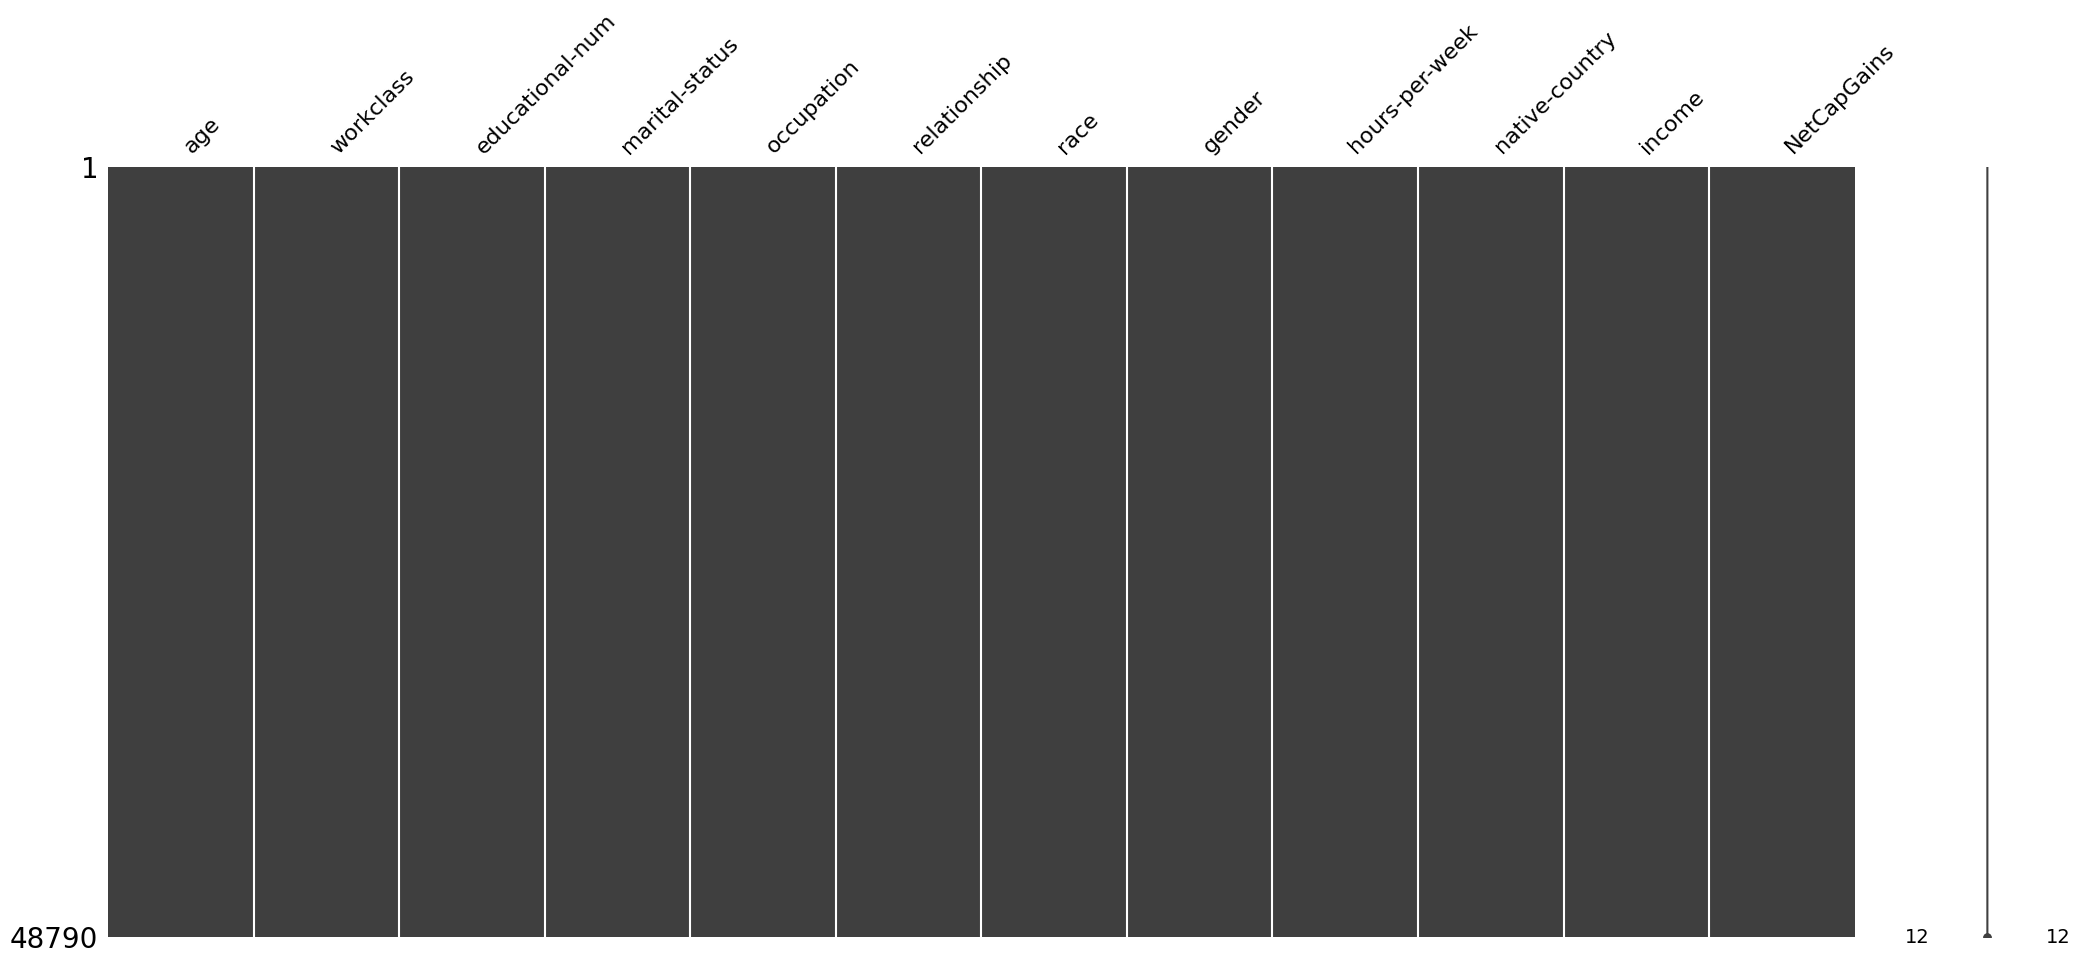

In [ ]:
# checking visually
msno.matrix(df);

In [ ]:
# looking for initital correlations
corr = df.corr(numeric_only=True)

[Text(0.5, 1.0, 'Correlation Heatmap')]

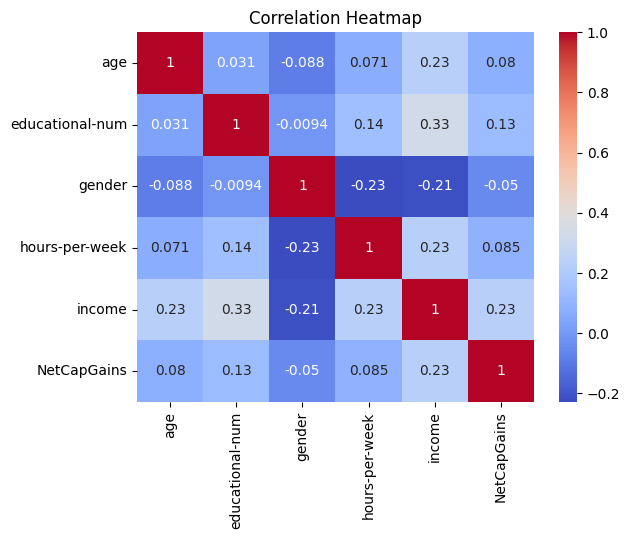

In [ ]:
# heatmap for correlation vis
ax = sns.heatmap(corr,annot=True, cmap='coolwarm');
ax.set(title='Correlation Heatmap')

**No particularly strong correlations upon initial inspection with the closest exception being education. Capital gains and hours worked also show some level of correlation**

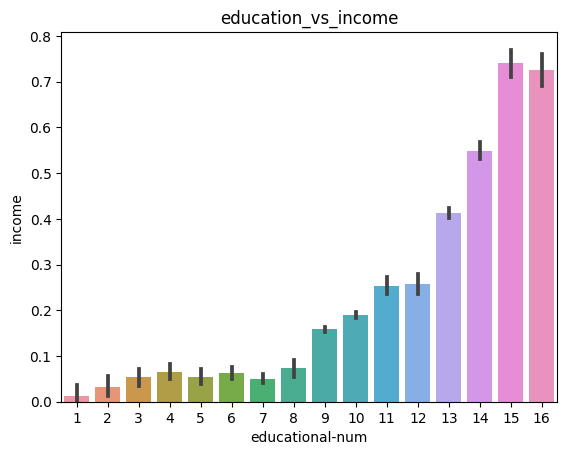

In [ ]:
ax = sns.barplot(data=df,x='educational-num', y='income',)
ax.set_title("education_vs_income");

Here we can see that there is, in fact, a direct correlation between educational achievement and income. Income is a binary in this dataset where less than 50k is represented as '0' and above is represented as '1'. These plots show the average of each educational attainment segmentation in relation to those assigned designations.

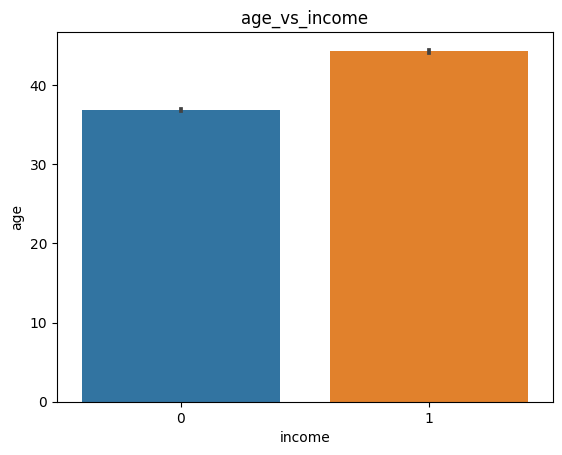

In [ ]:
ax = sns.barplot(data=df,x='income', y='age',)
ax.set_title("age_vs_income");

**Here, sub-50k respondants are represented by '0' and those making more than 50k are represented by '1'. This graph clearly illustrates that there is a correlation between average income and average age.**

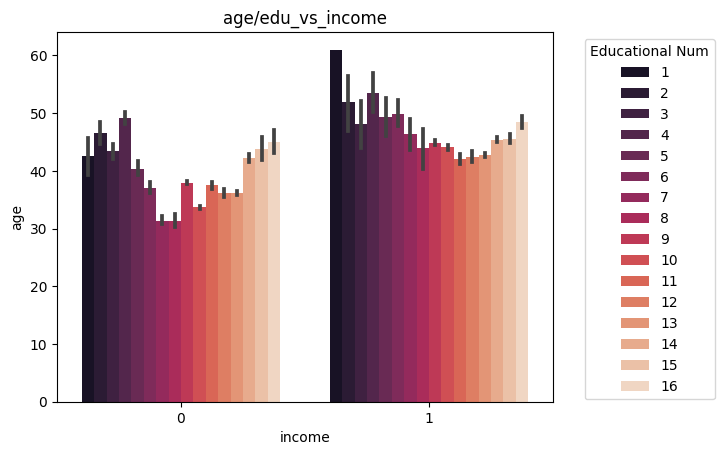

In [ ]:
ax = sns.barplot(data=df,x='income', y='age', hue = 'educational-num', palette='rocket')
# Move the legend to the right side
ax.legend(title='Educational Num', bbox_to_anchor=(1.05, 1), loc='upper left')
# Create a custom color palette using "rocket" colormap
custom_palette = sns.color_palette("rocket", as_cmap=True)
ax.set_title("age/edu_vs_income");

**Here we see the combination of age and education levels on income levels. Individuals in the lowest levels of educational segmentation need the most time and experience to attain the higher income bracket represented by '1'.**

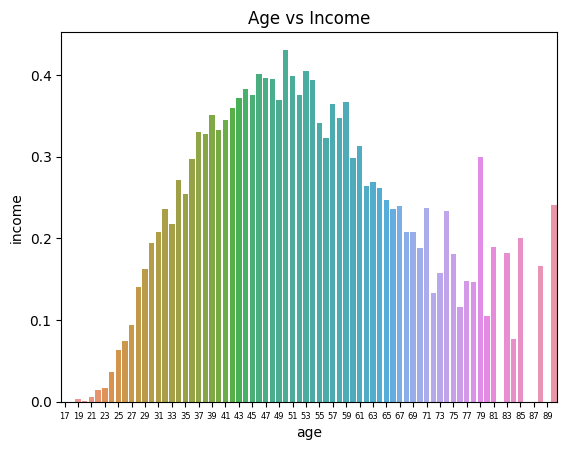

In [ ]:
ax = sns.barplot(data=df,x='age', y='income', ci=None)
ax.set_xticks(ax.get_xticks()[::2])
ax.tick_params(axis='x', labelsize=6)
ax.set_title("Age vs Income");

Text(0.5, 1.0, 'Gender/Race vs Income')

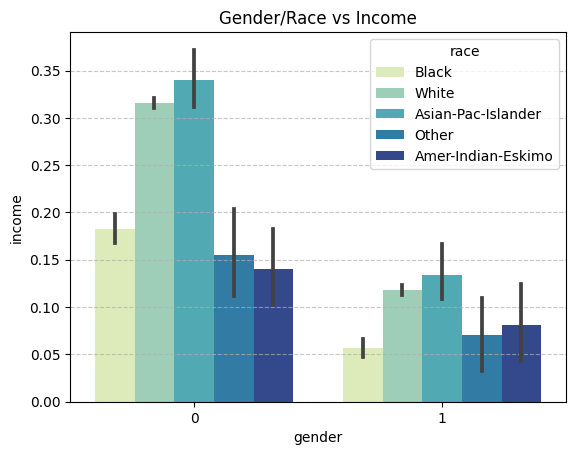

In [ ]:
custom_cmap = sns.color_palette("YlGnBu", n_colors=len(df['race'].unique()))
sns.set_palette(custom_cmap)
ax = sns.barplot(data=df, x='gender', y='income', hue='race')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.set_title("Gender/Race vs Income")

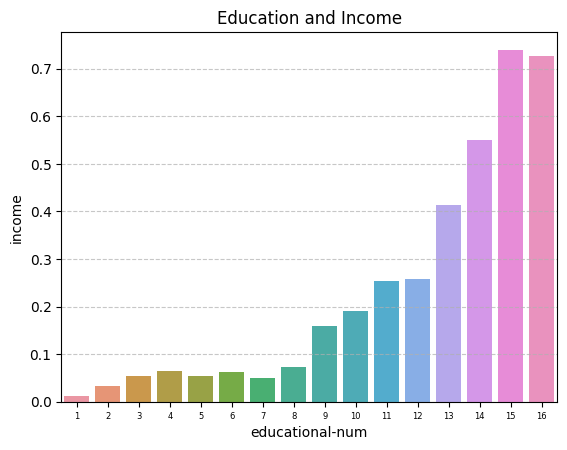

In [ ]:
ax = sns.barplot(data=df,x='educational-num', y='income', ci=None)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='x', labelsize=6)
ax.set_title("Education and Income");

In [ ]:
# create features matrix and target vector
X = df.drop('income', axis=1)
y = df['income']
# tts
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [ ]:
# preprocessing for numeric
# save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
imputer = SimpleImputer()
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(imputer, scaler)
num_pipe

Numeric Columns: Index(['age', 'educational-num', 'gender', 'hours-per-week', 'NetCapGains'], dtype='object')


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [ ]:
# making a numeric tuple
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 Index(['age', 'educational-num', 'gender', 'hours-per-week', 'NetCapGains'], dtype='object'))

In [ ]:
# ohe preprocessing
# save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# instantiate the preprocessors
imputer = SimpleImputer(strategy = 'most_frequent')
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# make pipeline with encoder
ohe_pipe = make_pipeline(imputer, ohe_encoder)
ohe_pipe

OneHotEncoder Columns: Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'native-country'],
      dtype='object')


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [ ]:
# ohe tuple
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
ohe_tuple

('categorical',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
        'native-country'],
       dtype='object'))

In [ ]:
# column transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple],
                                    verbose_feature_names_out=False,)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'educational-num', 'gender', 'hours-per-week', 'NetCapGains'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'native-country'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [ ]:
# fit and transform
X_train_tf = preprocessor.fit_transform(X_train)
X_test_tf = preprocessor.transform(X_test)

In [ ]:
# Perform PCA with 95% explained variance
pca = PCA(n_components=0.95)

In [ ]:
# make an instance of the model with default parameters
logreg_weighted = LogisticRegression(C=1.0, max_iter=500, random_state=42, class_weight='balanced')

# put model in a pipeline
logreg_weighted_pipe = make_pipeline(preprocessor, pca, logreg_weighted)
logreg_weighted_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'educational-num', 'gender', 'hours-per-week', 'NetCapGains'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'native-country'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    random_state=42))])

In [ ]:
# tuning options
logreg_weighted_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['age', 'educational-num', 'gender', 'hours-per-week', 'NetCapGains'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                

In [ ]:
# parameters to tune and the values to try
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none']}

In [ ]:
# instantiate GridSearchCV
grid_search = GridSearchCV(logreg_weighted_pipe, param_grid, n_jobs = -1, verbose = 1)

In [ ]:
# fit the Gridsearch on the training data
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'educational-num', 'gender', 'hours-per-week', 'NetCapGains'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy...
                                                                         Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'native-country'],
      dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('pca', PCA(n_components=0.95)),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=500,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                   1000],
                         'logisticregression__penalty': ['l1', 'l2',
                                                         'elasticnet',
                                                         'none']},
             verbose=1)

In [ ]:
# best parameters
grid_search.best_params_

{'logisticregression__C': 0.001, 'logisticregression__penalty': 'none'}

In [ ]:
# define the best version of the model
best_model = grid_search.best_estimator_

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.79      0.86     27841
           1       0.56      0.85      0.68      8751

    accuracy                           0.81     36592
   macro avg       0.75      0.82      0.77     36592
weighted avg       0.85      0.81      0.82     36592



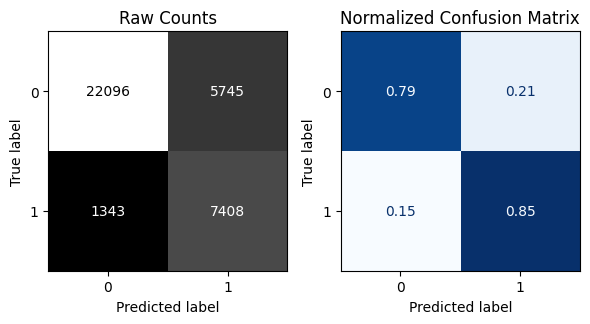


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      9268
           1       0.57      0.84      0.68      2930

    accuracy                           0.81     12198
   macro avg       0.75      0.82      0.77     12198
weighted avg       0.85      0.81      0.82     12198



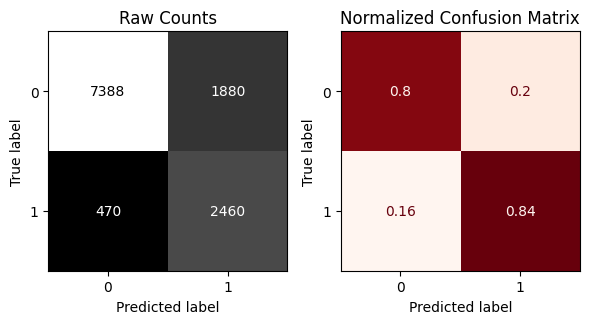

In [ ]:
# predict and evaluate with custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)

In [ ]:
# default KNN
knn = KNeighborsClassifier()

In [ ]:
# define KNN model pipeline
knn_pipe = make_pipeline(preprocessor, pca, knn)
# fit the model on the training data
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'educational-num', 'gender', 'hours-per-week', 'NetCapGains'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'native-country'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=0.95)),
                ('kneighborsclassifier', KNeighborsClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     27841
           1       0.78      0.69      0.73      8751

    accuracy                           0.88     36592
   macro avg       0.84      0.81      0.83     36592
weighted avg       0.88      0.88      0.88     36592



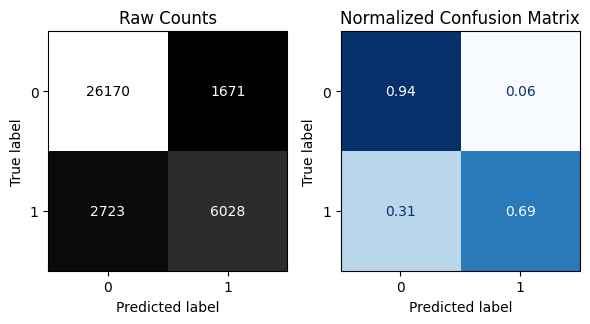


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      9268
           1       0.68      0.58      0.63      2930

    accuracy                           0.83     12198
   macro avg       0.78      0.75      0.76     12198
weighted avg       0.83      0.83      0.83     12198



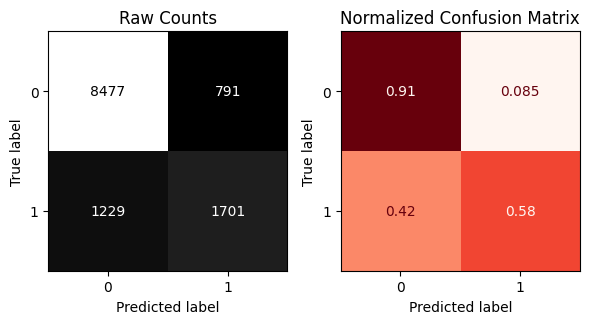

In [ ]:
# eval
evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test)

In [ ]:
# making every other value from the range (odd values)
nneighbors_list = list(range(1,33,2))
nneighbors_list

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

In [ ]:
# param list
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['age', 'educational-num', 'gender', 'hours-per-week', 'NetCapGains'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                

In [ ]:
# create param grid
params={'kneighborsclassifier__n_neighbors': nneighbors_list}

In [ ]:
# instaniate GridSearchCV
gs = GridSearchCV(knn_pipe, params, verbose=True, n_jobs=-1)
# fit gs on training data
gs.fit(X_train, y_train)
# obtain best param value for K
gs.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


{'kneighborsclassifier__n_neighbors': 21}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     27841
           1       0.74      0.61      0.67      8751

    accuracy                           0.86     36592
   macro avg       0.81      0.77      0.79     36592
weighted avg       0.85      0.86      0.85     36592



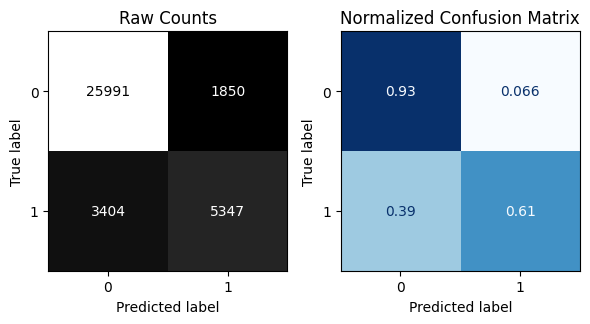


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      9268
           1       0.72      0.57      0.64      2930

    accuracy                           0.84     12198
   macro avg       0.80      0.75      0.77     12198
weighted avg       0.84      0.84      0.84     12198



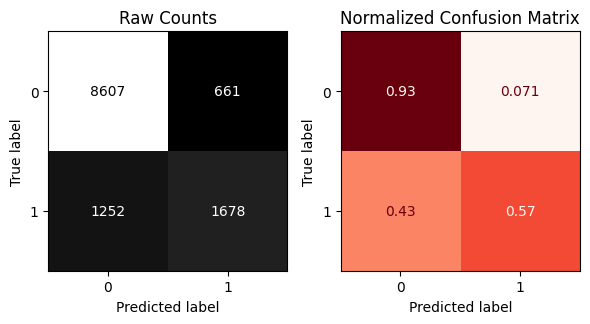

In [ ]:
# eval for cv best
evaluate_classification(gs.best_estimator_, X_train, y_train, X_test, y_test)

In [ ]:
# instantiate default random forest model
rf = RandomForestClassifier(random_state = 42)
# Model Pipeline
rf_pipe = make_pipeline(preprocessor, pca, rf)

In [ ]:
# fit the model pipeline on the training data only
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'educational-num', 'gender', 'hours-per-week', 'NetCapGains'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'native-country'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=0.95)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     27841
           1       0.96      0.93      0.95      8751

    accuracy                           0.97     36592
   macro avg       0.97      0.96      0.97     36592
weighted avg       0.97      0.97      0.97     36592



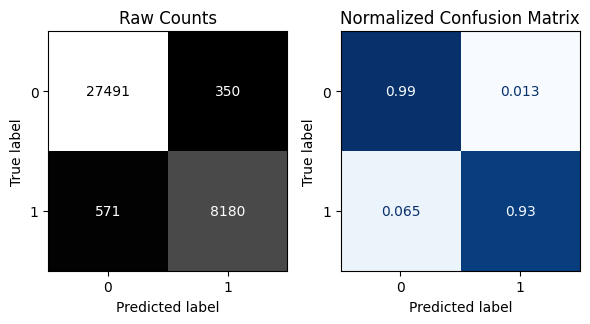


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      9268
           1       0.69      0.58      0.63      2930

    accuracy                           0.84     12198
   macro avg       0.78      0.75      0.76     12198
weighted avg       0.83      0.84      0.83     12198



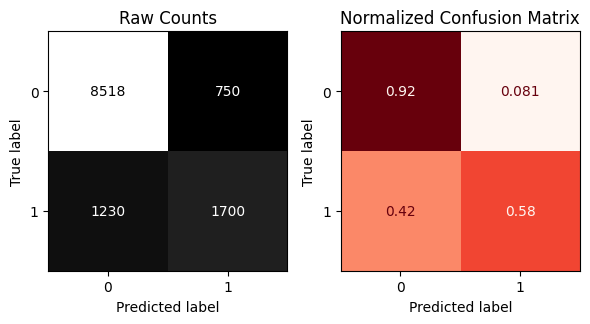

In [ ]:
# eval default model
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test)

In [ ]:
# parameters for tuning
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['age', 'educational-num', 'gender', 'hours-per-week', 'NetCapGains'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                

In [ ]:
# create a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# define the parameter grid for the Random Forest classifier
param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4]}

# instantiate the grid search with the pipeline and parameter grid
gridsearch = GridSearchCV(rf_pipe, param_grid, n_jobs=-1, cv=2, verbose=1, scoring='recall_macro')

# fit the grid search on training data
gridsearch.fit(X_train, y_train)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


In [ ]:
# best parameters
gridsearch.best_params_

In [ ]:
# define the best version of the model
best_model = grid_search.best_estimator_

In [ ]:
# predict and evaluate with custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)

**All three models performed remarkably similarly. There are slight variations in precision and recall but all three come in with an F-1 score of .77 +/- 0.2. KNN did edge the field in the regard with an F-1 at .79. The goal of the models was overall predictive success so the variations in precision and recall don't tip the scales heavily in favor of one model. 0.2 isn't much variation in terms of F-1 scores but if one is forced to choose a model by that metric, taking a Bayesian approach yields the only conclusion; KNN is the best model for predicting income outcomes with this dataset, of the three models tested here.**